In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  %pip install --quiet git+https://github.com/raultruco/cryptowatson-indicators#egg=cryptowatson-indicators

import backtrader as bt
from cryptowatson_indicators.backtrader import RebalanceStrategy, WeightedDCAStrategy, DCAStrategy, HodlStrategy
from cryptowatson_indicators.datas import TickerDataSource
from cryptowatson_indicators.indicators import FngBandIndicator, RainbowBandIndicator
from tabulate import tabulate
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200
# %matplotlib inline
%matplotlib widget

# Global variables
# Data sources
ticker_data_source = TickerDataSource().load()
# Indicators
fng_indicator = FngBandIndicator()
rainbow_indicator = RainbowBandIndicator(ticker_data_source.to_dataframe())

# Optimise strategies

Usage...

### Variables

In [2]:
# Fixed variables
start                = '01/01/2021'   # start date of the simulation. Ex: '01/08/2020' or None
end                  = '31/12/2021'           # end date of the simulation. Ex: '01/08/2020' or None
initial_cash         = 10000.0        # initial broker cash. Default 10000 usd
base_buy_amount  = 100            # Amount purchased in standard DCA
fng_weighted_multipliers = [1.5, 1.25, 1, 0.75, 0.5]    # buy amount multipliers (weighted) for each band
fng_rebalance_percents   = [85, 65, 50, 15, 10]         # rebalance percentages of BTC / total for each band
rwa_weighted_multipliers = [0, 0.1, 0.2, 0.3, 0.5, 0.8, 1.3, 2.1, 3.4]
rwa_rebalance_percents = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Range variables (to compare optimization)
min_order_period_list = range(4, 8)              # Minimum period in days to place orders

# Other options
plot_results         = False

### Run strategies!

In [3]:
def run(strategy_class, **kwargs):
    cerebro = bt.Cerebro(stdstats=False, maxcpus=0, runonce=True, exactbars=False, optdatas=True)
    cerebro.broker.set_coc(True)

    # Add strategy
    cerebro.optstrategy(strategy_class,
                        log=(False,),
                        debug=(False,),
                        **kwargs)

    # Add data feed
    cerebro.adddata(ticker_data_source.to_backtrade_feed(start, end))

    # Add cash to the virtual broker
    cerebro.broker.setcash(initial_cash)    # default: 10k

    cerebro_results = cerebro.run(optreturn=False)

    return cerebro_results


rebalance_run_results = list()
wdca_run_results = list()

# HODL
run_result = run( \
    strategy_class=HodlStrategy, \
    percent=(100,), \
)
rebalance_run_results.extend(map(lambda result: result[0], run_result))

# Rebalance strategy with Fear and Greed indicator
run_result = run( \
    strategy_class=RebalanceStrategy, \
    band_indicator=(fng_indicator,),
    min_order_period=min_order_period_list, \
    rebalance_percents=(fng_rebalance_percents,), \
)
rebalance_run_results.extend(map(lambda result: result[0], run_result))

# Rebalance strategy with Rainbow indicator
run_result = run( \
    strategy_class=RebalanceStrategy, \
    band_indicator=(rainbow_indicator,),
    min_order_period=min_order_period_list, \
    rebalance_percents=(rwa_rebalance_percents,), \
)
rebalance_run_results.extend(map(lambda result: result[0], run_result))

# Standard DCA
run_result = run( \
    strategy_class=DCAStrategy, \
    buy_amount=(base_buy_amount,), \
    min_order_period=min_order_period_list, \
)
wdca_run_results.extend(map(lambda result: result[0], run_result))

# Weighted Av strategy with Fear and Greed indicator
run_result = run( \
    strategy_class=WeightedDCAStrategy, \
    band_indicator=(fng_indicator,),
    base_buy_amount=(base_buy_amount,), \
    min_order_period=min_order_period_list, \
    weighted_multipliers=(fng_weighted_multipliers,), \
)
wdca_run_results.extend(map(lambda result: result[0], run_result))

# Weighted Av strategy with Rainbow indicator
run_result = run( \
    strategy_class=WeightedDCAStrategy, \
    band_indicator=(rainbow_indicator,),
    base_buy_amount=(base_buy_amount,), \
    min_order_period=min_order_period_list, \
    weighted_multipliers=(rwa_weighted_multipliers,), \
)
wdca_run_results.extend(map(lambda result: result[0], run_result))


# Sort results by pnl_value
sorted_rebalance_run_results = sorted(rebalance_run_results, key=lambda strategy: float(strategy.pnl_value), reverse=True)
sorted_wdca_run_results = sorted(wdca_run_results, key=lambda strategy: float(strategy.pnl_value), reverse=True)

### Show the results

In [4]:

column_keys = ['name', 'pnl_value', 'pnl_percent', 'params']
column_headers = ['Strategy', 'PNL USDT', 'PNL %', 'Parameters']

sorted_rebalance_run_details = map(lambda strategy: strategy.describe(keys=column_keys), sorted_rebalance_run_results)
display(Markdown('#### Rebalance results:'))
print(tabulate([details.values() for details in sorted_rebalance_run_details], 
                tablefmt="github", 
                headers=column_headers, 
                floatfmt="+.2f"))

sorted_wdca_run_details = map(lambda strategy: strategy.describe(keys=column_keys), sorted_wdca_run_results)
display(Markdown('#### Weighted DCA results:'))
print(tabulate([details.values() for details in sorted_wdca_run_details], 
                tablefmt="github", 
                headers=column_headers, 
                floatfmt="+.2f"))

#### Rebalance results:

| Strategy                 |   PNL USDT |   PNL % | Parameters                         |
|--------------------------|------------|---------|------------------------------------|
| HODL 100%                |   +6262.52 |  +62.63 | 100%                               |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 4 days |10,20,30,40,50,60,70,80,90 |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 5 days |10,20,30,40,50,60,70,80,90 |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 6 days |10,20,30,40,50,60,70,80,90 |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 7 days |10,20,30,40,50,60,70,80,90 |
| Rebalance Fear and Greed |   +1006.53 |  +10.07 | 4 days |85,65,50,15,10             |
| Rebalance Fear and Greed |    +978.52 |   +9.79 | 5 days |85,65,50,15,10             |
| Rebalance Fear and Greed |    +931.54 |   +9.32 | 7 days |85,65,50,15,10             |
| Rebalance Fear and Greed |    +802.73 |   +8.03 | 6 days |85,65,50,15,10             |


#### Weighted DCA results:

| Strategy                    |   PNL USDT |   PNL % | Parameters                                      |
|-----------------------------|------------|---------|-------------------------------------------------|
| Weighted DCA Fear and Greed |    +664.96 |   +6.65 | 4 days |100$ |1.5,1.25,1,0.75,0.5               |
| Weighted DCA Fear and Greed |    +468.43 |   +4.68 | 5 days |100$ |1.5,1.25,1,0.75,0.5               |
| Weighted DCA Fear and Greed |    +431.02 |   +4.31 | 6 days |100$ |1.5,1.25,1,0.75,0.5               |
| DCA 100.00$                 |    +401.20 |   +4.01 | 4 days |100$ |x1                                |
| Weighted DCA Fear and Greed |    +379.43 |   +3.79 | 7 days |100$ |1.5,1.25,1,0.75,0.5               |
| Weighted DCA Rainbow        |    +379.19 |   +3.79 | 4 days |100$ |0,0.1,0.2,0.3,0.5,0.8,1.3,2.1,3.4 |
| Weighted DCA Rainbow        |    +284.66 |   +2.85 | 5 days |100$ |0,0.1,0.2,0.3,0.5,0.8,1.3,2.1,3.4 |
| DCA 100.00$                 |    +283.42 |   +2.83 | 

### Plot results

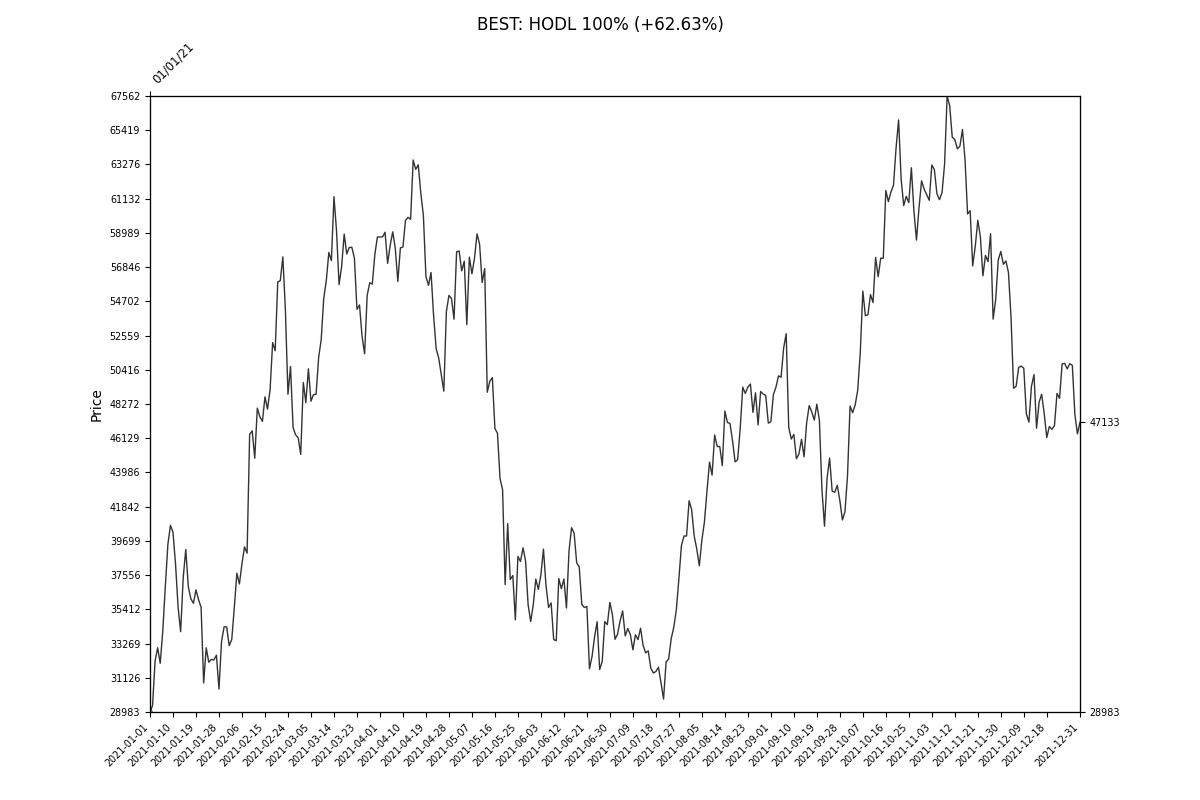

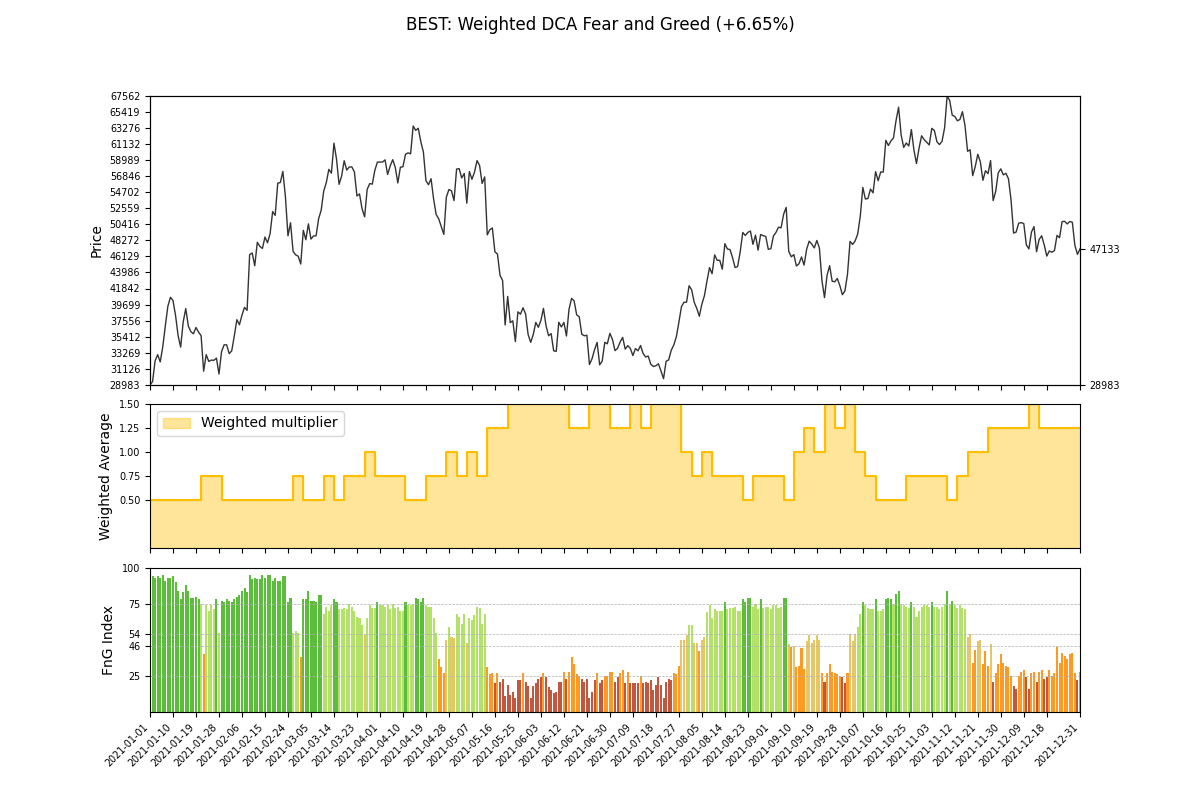

In [5]:
plot_results = True
plot_only_winner = True

if plot_results:
    for i in range(0, len(sorted_rebalance_run_results)):
        sorted_rebalance_run_results[i].plot(title_prefix='BEST: ' if i == 0 else '', title_suffix=f" ({sorted_rebalance_run_results[i].pnl_percent:+.2f}%)")

        if plot_only_winner:
            break
    
    for i in range(0, len(sorted_wdca_run_results)):
        sorted_wdca_run_results[i].plot(title_prefix='BEST: ' if i == 0 else '', title_suffix=f" ({sorted_wdca_run_results[i].pnl_percent:+.2f}%)")

        if plot_only_winner:
            break
